# Case Discriminating OCR Neural Network with Tensorflow

This notebook loads EMNIST 'By_Class' tensorflow dataset and trains a model capable of recognizing letters a-Z with case.

Online demo: <https://subprotocol.com/system/cdnn.html>


In [1]:
import seaborn as sn
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import tensorflowjs as tfjs
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# generates this factor * <size of max class>. Allows some chance for
# a character to be re-used in different places and sizes
TRAINING_SIZE_FACTOR=1.25

# 0-9,A-Z,a-z  This model drops 0-9
NUM_CLASSES = 62
CLASSES = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
CASE_AMBIGUOUS_CLASSES = ['c','i','j','k','l','m','o','p','s','u','v','w','x','y','z']

# turn this into a tensor, it will be handy later
case_ambiguous_mask = [cls in CASE_AMBIGUOUS_CLASSES for cls in CLASSES]
case_ambiguous_mask = tf.constant(case_ambiguous_mask)

# standard MNIST/EMNIST image normalization
def normalize_image(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.transpose(image, perm=[1, 0, 2])
    image = image / 255.0
    return image, label

def prepare(ds):
    # filter out numbers
    ds = ds.filter(lambda image, label: label > 9)

    # transpose and convert data to be within [0.0,1.0]
    ds = ds.map(normalize_image)

    # one hot encode the label
    ds = ds.map(lambda image, label: (image, tf.one_hot(label, depth=NUM_CLASSES)))

    return ds

# load dataset
(ds_train, ds_test), ds_info = tfds.load(
    "emnist/byclass",
    split=["test", "test"],
    #split=["train[:1%]", "test[:1%]"],
    shuffle_files=False,
    as_supervised=True,
    with_info=True
)

ds_train = prepare(ds_train)
ds_test = prepare(ds_test)


Character indexes used by EMNIST 'By_Class' dataset.

| Characters | Min | Max |
|----------- | --- | --- |
| 0 - 9      | 0   | 9   |
| A - Z      | 10  | 35  |
| a - z      | 36  | 61  |


### Case Ambiguous Letters

Below we pluck out a few examples of letters that are difficult to distinguish upper vs. lower case.

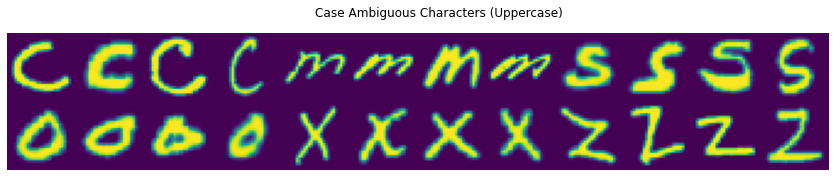

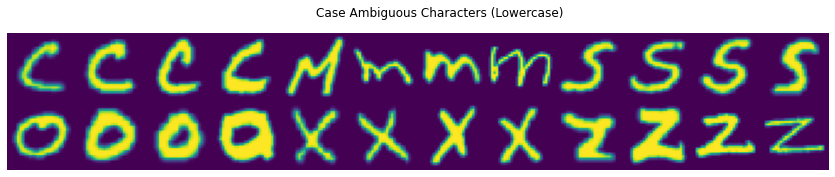

In [3]:
def show(images, size=(12, 12), title="untitled"):
    images = images[:(size[0] * size[1])]
    fig = plt.figure(figsize=size)
    i = 0
    for image in images:
        fig.add_subplot(size[0], size[0], i + 1)
        plt.axis('off')
        plt.imshow(image)
        i += 1

    fig.tight_layout(rect=[0, 0.0, 0.95, 0.95], pad=0)
    plt.suptitle(title)
    plt.show()

def filter_examples(ds, char_class, n=4):
    return ds.filter(lambda _, label: tf.argmax(label) == char_class).take(n)

def collect_examples(ds, classes):
    r = None
    for cls in classes:
        tmp = filter_examples(ds, cls)
        r = tmp if r is None else r.concatenate(tmp)
    return r

def display_examples(ds, classes, title="Untitled"):
    examples = collect_examples(ds, classes=[CLASSES.index(ch) for ch in classes])
    examples = examples.map(lambda image, _: image).as_numpy_iterator()
    show(list(examples), title=title)

display_examples(ds_train, "CMSOXZ", title="Case Ambiguous Characters (Uppercase)")
display_examples(ds_train, "cmsoxz", title="Case Ambiguous Characters (Lowercase)")

### Balancing the dataset

To balance the dataset we duplicate examples when needed; we'll scale and translate them later. To achieve this we compute a factor for each class. If a class has a factor of 2.3, it means each time you see an example, 30% of the time add three additional examples and 70% of the time only add 2.

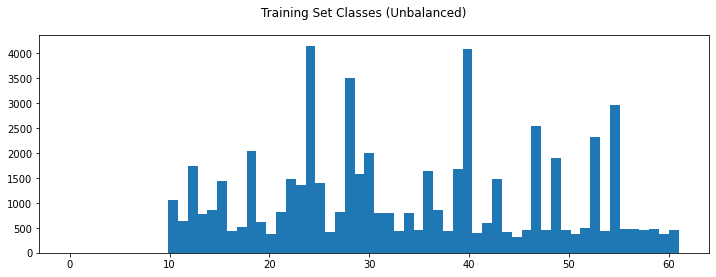

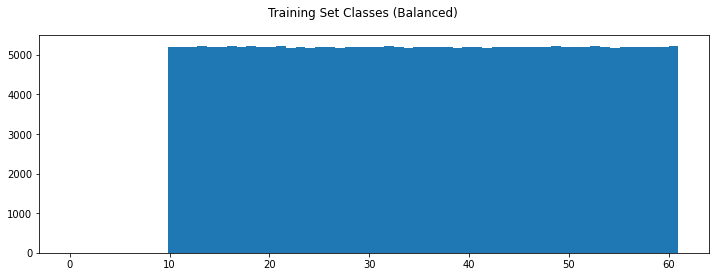

In [4]:
class_histogram = ds_train\
    .map(lambda _, label: label)\
    .reduce(tf.zeros([NUM_CLASSES], tf.float32), lambda a, b: a + b)

plt.figure(figsize=(12,4))
plt.suptitle("Training Set Classes (Unbalanced)")
plt.hist(range(NUM_CLASSES), weights=class_histogram.numpy(), bins=NUM_CLASSES)

# class factors needed to balance the training examples. 3.12 means for that class for each example:
#  add 3 additional
#  plus one more 12% of the time
class_factors = (TRAINING_SIZE_FACTOR*tf.reduce_max(class_histogram) - class_histogram) / class_histogram

def class_balancer(image, label):
    factor = class_factors[tf.argmax(label)]
    extras = tf.cast(factor, dtype=tf.int64)
    prob = factor - tf.math.floor(factor)
    maybe_another = tf.cond(
        tf.random.uniform([]) <= prob,
        lambda: tf.constant(1, dtype=tf.int64),
        lambda: tf.constant(0, dtype=tf.int64)
    )
    return tf.data.Dataset.from_tensors((image, label)).repeat(1 + extras + maybe_another)

ds_train_balanced = ds_train.flat_map(class_balancer)

class_histogram_balanced = ds_train_balanced\
    .map(lambda _, label: label)\
    .reduce(tf.zeros(NUM_CLASSES, tf.float32), lambda a, b: a + b)

plt.figure(figsize=(12,4))
plt.suptitle("Training Set Classes (Balanced)")
plt.hist(range(NUM_CLASSES), weights=class_histogram_balanced.numpy(), bins=NUM_CLASSES);

### Image Post Processing

We want to put in some random variation. The algorithm roughly sizes glyphs based on this matrix:

| &nbsp;                 | Lowercase     | Uppercase     |
|------------------------|---------------|---------------|
| __Case Ambiguous__     | Small-Med     | Med-Large     |
| __Not Case Ambiguous__ | Small-Large   | Small-Large   |


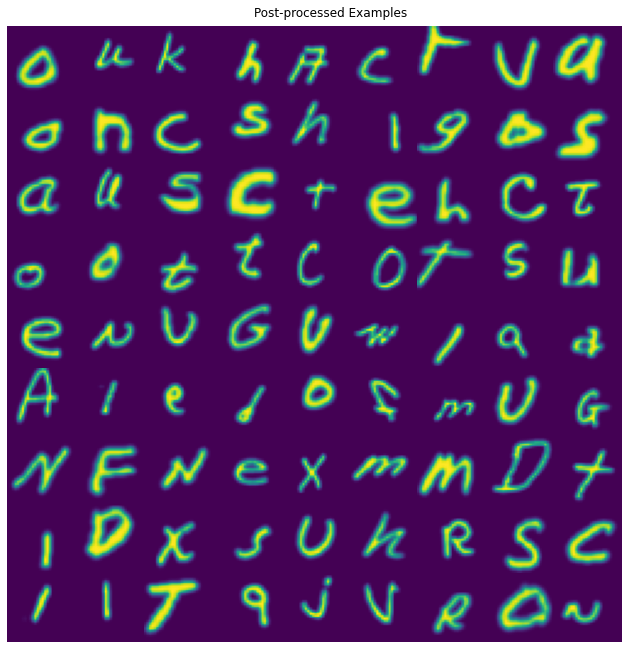

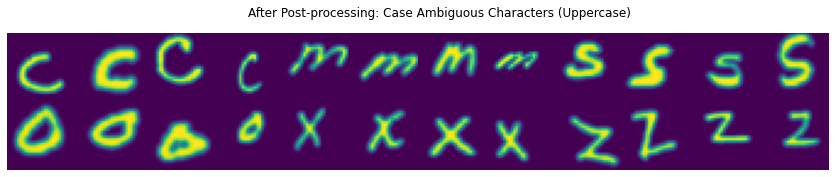

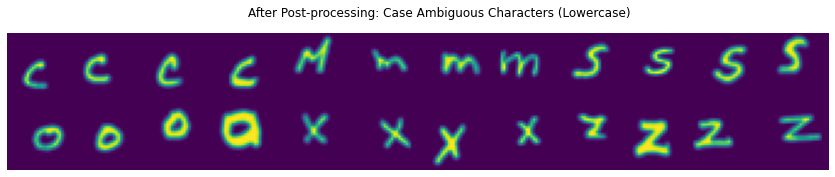

In [5]:
# shrinks images within a uniform range and maintains size
def shrink(image, min=12, max=28):
    size = tf.random.uniform(shape=[], minval=min, maxval=max, dtype=tf.int32)
    image = tf.image.resize(image, size=(size,size), antialias=True)
    offset = (28-size)//2
    image = tf.image.pad_to_bounding_box(
        image,
        offset_height=offset,
        offset_width=offset,
        target_height=28,
        target_width=28
    )
    return image

# adjust images by deltas uniformly
def perturbe(image, dx=(-5,5), dy=(-5,5)):
    dx = tf.random.uniform(shape=[], minval=dx[0], maxval=dx[1], dtype=tf.float32)
    dy = tf.random.uniform(shape=[], minval=dy[0], maxval=dy[1], dtype=tf.float32)
    image = tfa.image.translate(
        images = image,
        translations = [dx,dy],
        interpolation = 'bilinear',
        fill_mode = 'constant'
    )
    return image

# this applies random transformations to the data.  There are
# four transformation paths based on:
#   case ambiguous = true/false
#   and lowercase = true/false
def transform_examples(image, label):
    index = tf.argmax(label)

    result_image = tf.cond(
        case_ambiguous_mask[index],
        # character is case ambiguous
        lambda: tf.cond(
            tf.argmax(label) >= 36,
            # lower case characters are made a bit smaller perturbed a bit more
            lambda: perturbe(shrink(image, 14, 21), dx=(-5,5), dy=(-5,5)),
            # uppercase gets less of similar treatment
            lambda: perturbe(shrink(image, 25, 28), dx=(-2,2), dy=(-2,2)),
        ),
        # character is NOT case ambiguous
        lambda: tf.cond(
            tf.argmax(label) >= 36,
            # lower case- it's not size sensitive so allow the whole gamut
            lambda: perturbe(shrink(image, 14, 28), dx=(-4,4), dy=(-4,4)),
            # uppercase- allow some variability, but should generally be bigger
            lambda: perturbe(shrink(image, 18, 28), dx=(-3,3), dy=(-3,3)),
        )
    )

    return result_image, label


# display some examples of what the transformation looks like
examples = ds_train
examples = examples.take(9*9)
examples = examples.map(transform_examples)
examples = examples.map(lambda image, _: image)
show(list(examples.as_numpy_iterator()), size=(9, 9), title="Post-processed Examples")

# show some case ambiguous examples after post-processing
ds_post_processed = ds_train.map(transform_examples)
display_examples(ds_post_processed, "CMSOXZ", title="After Post-processing: Case Ambiguous Characters (Uppercase)")
display_examples(ds_post_processed, "cmsoxz", title="After Post-processing: Case Ambiguous Characters (Lowercase)")

### Training

At this point we're ready to train the network.

In [6]:
# transform both train and test datasets
ds_train_balanced = ds_train_balanced.map(transform_examples)
ds_test = ds_test.map(transform_examples)

# training pipeline
ds_train_batches = ds_train_balanced\
    .cache()\
    .shuffle(16384)\
    .batch(512)\
    .prefetch(tf.data.experimental.AUTOTUNE)

# evaluation pipeline
ds_test_batches = ds_test\
    .batch(512)\
    .cache()\
    .prefetch(tf.data.experimental.AUTOTUNE)

model = tf.keras.models.Sequential([
    layers.Conv2D(32, kernel_size=(5,5), activation='relu', input_shape=(28,28,1)),
    layers.MaxPool2D((2,2), strides=(2,2)),
    layers.Conv2D(54, kernel_size=(5,5), activation='relu'),
    layers.MaxPool2D((2,2), strides=(2,2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(NUM_CLASSES, activation="softmax")
])

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# train model

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3
)

tensorboard = tf.keras.callbacks.TensorBoard(log_dir=".logs")

history = model.fit(
    ds_train_batches,
    epochs=30,
    validation_data=ds_test_batches,
    callbacks=[early_stopping, tensorboard],
    verbose=2
)

# save our model
model.save("cdnn.h5")

# also save a javascript version of our model
tfjs.converters.save_keras_model(model, ".js/")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 54)          43254     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 54)          0         
_________________________________________________________________
flatten (Flatten)            (None, 864)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               442880    
_________________________________________________________________
dense_1 (Dense)              (None, 62)                3

### Confusion Matrix Analysis

Having made a few training runs I tend to see validation accuracy between 88% and 94%.

The confusion matrix for both the training and test validation datasets is provided below.  There is some slight confusion around glyph similar letters (i, l, L) as well as case similar letters.  Nothing too bad though.


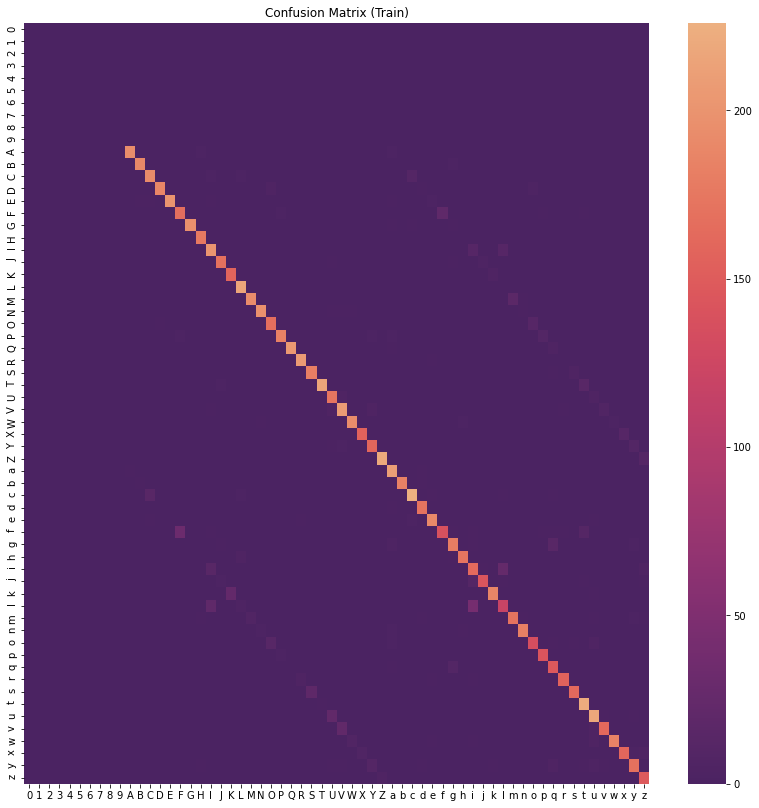

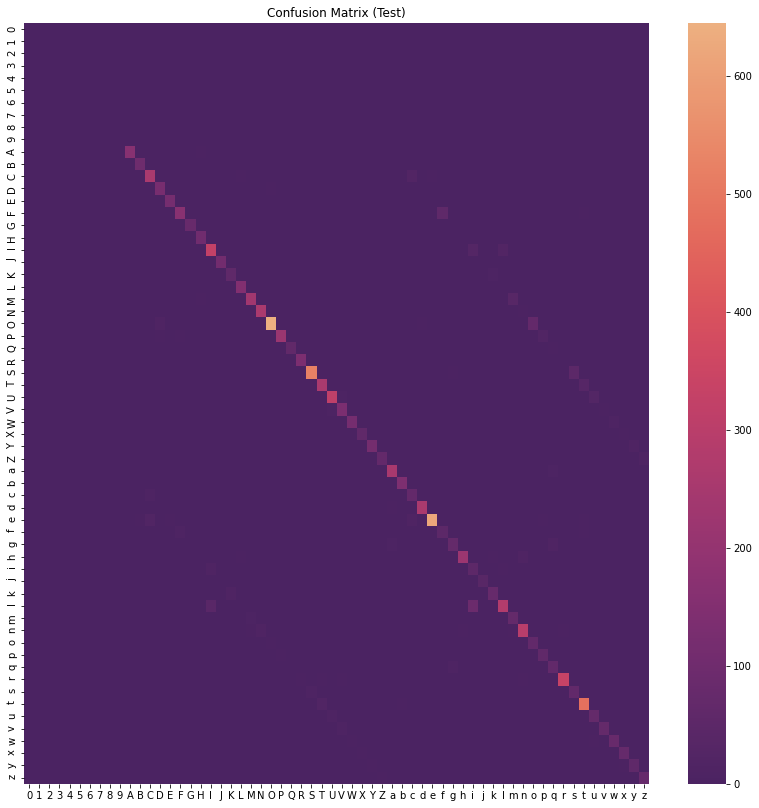

In [7]:
def confusion(examples, title="Untitled Confusion Matrix"):
    labels = examples.map(lambda image, label: label).unbatch()
    labels = [tf.argmax(x) for x in list(labels.as_numpy_iterator())]

    predictions = model.predict(examples)
    predictions = [tf.argmax(x) for x in list(predictions)]

    confusion_matrix = tf.math.confusion_matrix(
        labels=labels,
        predictions=predictions,
        num_classes=NUM_CLASSES
    )

    plt.figure(figsize = (14,14))
    plt.title(title)
    sn.heatmap(
        confusion_matrix,
        annot=False,
        xticklabels=[ch for ch in CLASSES],
        yticklabels=[ch for ch in CLASSES],
        cmap="flare_r"
    )

MAX_EXAMPLES=10000
confusion(
    examples=ds_train_batches
        .take(20) # take 20 batches
        .unbatch()
        .batch(MAX_EXAMPLES)
        .take(1)
        .cache(), # cache since the dataset is shuffled and we'd have mismatched labels and predictions otherwise
    title="Confusion Matrix (Train)"
)

confusion(
    examples=ds_test_batches
        .unbatch()
        .batch(MAX_EXAMPLES)
        .take(1),
    title="Confusion Matrix (Test)"
)